In [1]:
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import copy
import numpy as np
import pickle as pkl

### Below please use appropriate path to load images from provided Kaggle Data

In [2]:
## Code shamelessly borrowed from Albumentations Website
class RoadSegmentData(Dataset):
    def __init__(self, image_names, image_path, mask_path, transform = None):
        self.image_names = image_names
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform
        self.num_data = len(self.image_names)
        
    def __getitem__(self, idx):
        image_filename = self.image_names[idx]
        image = cv2.imread(os.path.join(self.image_path, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.mask_path, image_filename), cv2.IMREAD_UNCHANGED,
        )
        if self.transform is not None:
            transformed_image = self.transform(image = image,
                                              mask = mask)
            image = transformed_image['image']
            mask = transformed_image['mask']
        return image, mask
    
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

In [3]:
train_images = glob.glob("../cil-road-segmentation-2022/training/images/*")
final_train_list = []
for img in train_images:
    final_train_list.append(img.split('/')[-1])

In [4]:
train_transform = A.Compose(
    [
        A.VerticalFlip(),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Transpose(),
        ToTensorV2(),
    ]
)


## Replace with appropriate path on your local machines
data = RoadSegmentData(image_names = final_train_list, 
                       image_path = '../cil-road-segmentation-2022/training/images/',
                       mask_path = '../cil-road-segmentation-2022/training/groundtruth/',
                       transform = train_transform)

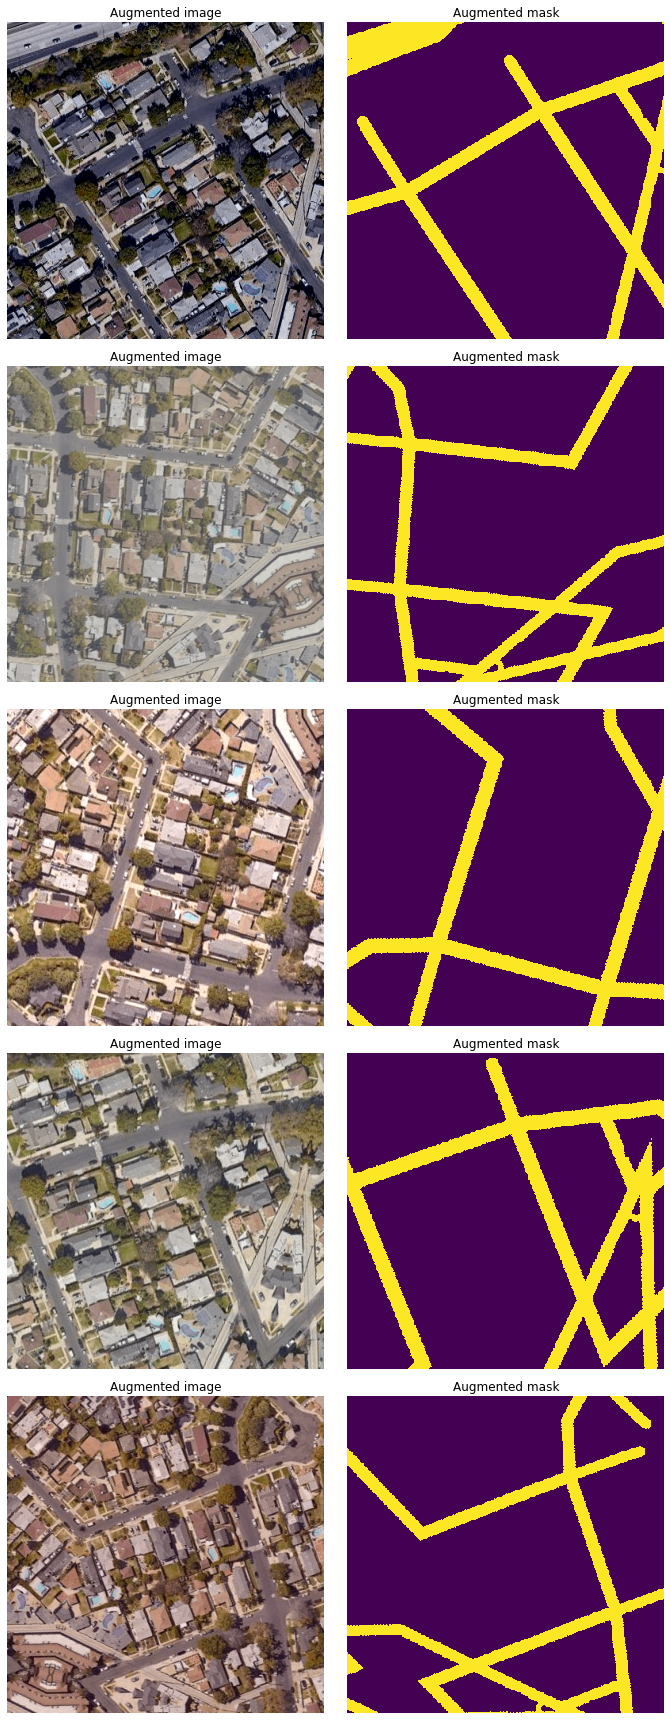

In [5]:
visualize_augmentations(data, 10, 5)

## Massachusetts Dataset Clear White Areas and Create New Dataset

Use Relative Paths on your computers

In [6]:
gt_train = glob.glob("../road_segmentation_ideal/training/output/*")

In [7]:
gt_train_images = [img.split('/')[-1] for img in gt_train]

In [8]:
image_path = glob.glob("../road_segmentation_ideal/training/input/*")

In [9]:
final_image_path = []
for img in gt_train_images:
    final_image_path.append("../road_segmentation_ideal/training/input/"+img)

In [ ]:
clean_images = []
for i, img in enumerate(final_image_path[:20]):
    img_ = cv2.imread(img)
    # Pick 100000 random indices
    # Check if less than 0.01 percent of the location (we are being too strict here I guess)
    x = np.random.randint(0, 2250000, 100000)
    sval = sum(img_[:, :, 0].reshape(-1)[x]==255)
    if sval/1500/1500*100 < 0.01:
        clean_images.append(img)
    else:
        pass

In [ ]:
import pickle as pkl
pkl.dump( clean_images, open("massachussetts_clean_images.pkl","wb"), protocol=pkl.HIGHEST_PROTOCOL)

In [12]:
clean_images = pkl.load(open("massachussetts_clean_images.pkl", "rb"))

### Random Cropping

In [13]:
clean_mask = []

for img_path in clean_images:
    val = img_path.split('/')[-1]
    path = "../road_segmentation_ideal/training/output/" + val
    clean_mask.append(path)

In [14]:
train_transform = A.Compose([A.RandomCrop(200, 200), A.RandomScale(), A.Resize(400, 400)])

In [15]:
img, mask = cv2.imread(clean_images[200]), cv2.imread(clean_mask[200])


/home/deepak/anaconda3/envs/cil/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


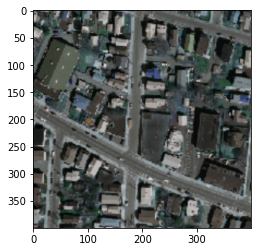

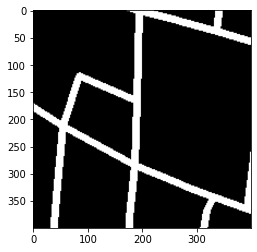

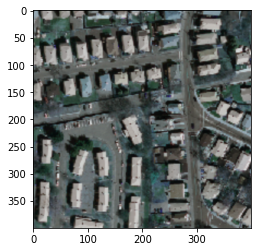

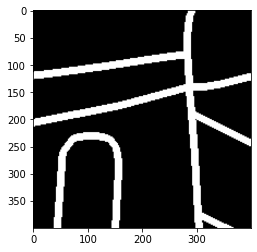

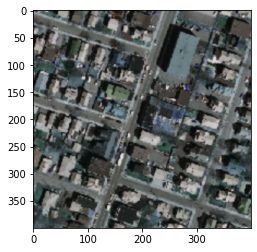

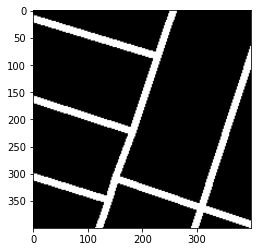

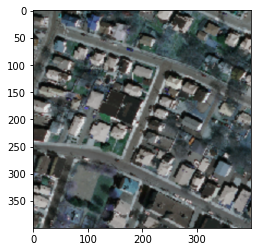

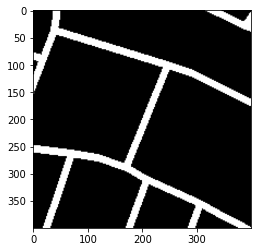

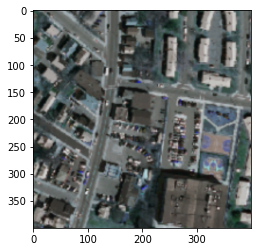

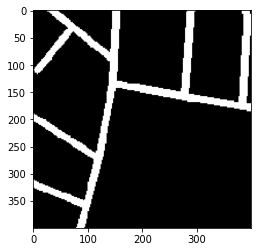

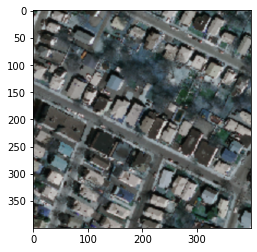

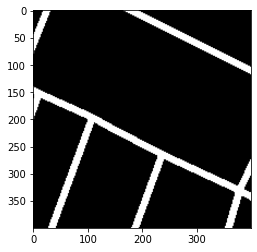

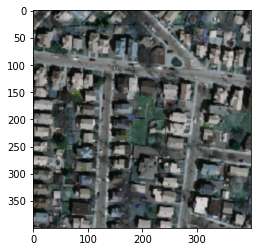

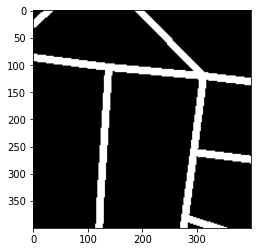

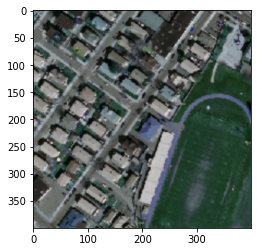

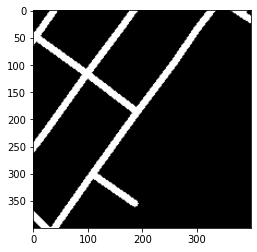

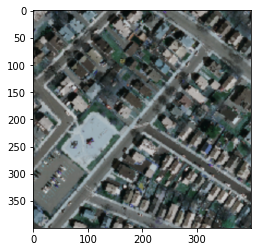

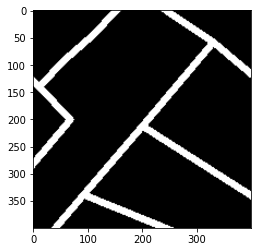

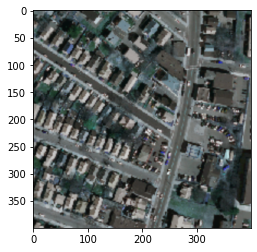

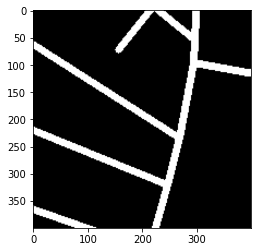

<Figure size 432x288 with 0 Axes>

In [16]:
for ix in range(10):
    transformed = train_transform(image = img, mask = mask)
    if transformed['mask'][:, :, 0].sum()/400/400*100<10:
        continue
    plt.imshow(transformed['image'])
    plt.figure()
    plt.imshow(transformed['mask'])
    plt.figure()

### Save Images

In [ ]:
import os
os.makedirs("new_images")
os.makedirs("new_labels")

In [ ]:
for ix in range(len(clean_images)):
    img, mask = cv2.imread(clean_images[ix]), cv2.imread(clean_mask[ix])
    for i in range(5):
        transformed = train_transform(image = img, mask = mask)
        if transformed['mask'][:, :, 0].sum()/200/200*100<10:
            continue
        else:
            cv2.imwrite('new_images' + '/' + clean_images[ix].split('/')[-1][:-4] + '-' + str(i + 1) + '.png', transformed['image'])
            cv2.imwrite('new_labels' + '/' + clean_mask[ix].split('/')[-1][:-4] + '-' + str(i + 1) + '.png', transformed['mask'])